In [ ]:
# upload files from 20th march to 29th march

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data directory (adjust for Colab/local setup)
data_dir = '/content'

# Initialize exponential weights
def initialize_weights(n_days=5, decay=0.5):
    weights = np.exp(-decay * np.arange(n_days))
    return weights / np.sum(weights)

# Compute SES
def calculate_ses(data, weights):
    blocks_per_day = 96
    num_days = len(data) // blocks_per_day
    result = []
    for block in range(blocks_per_day):
        block_values = [
            data['load'].iloc[block + (num_days - i - 2) * blocks_per_day]
            for i in range(len(weights))
        ]
        ses_value = np.sum(np.array(block_values) * weights)
        result.append(ses_value)
    return result


In [ ]:
import os

# Define prediction folder path
prediction_dir = '/content/prediction'
os.makedirs(prediction_dir, exist_ok=True)  # Ensure folder exists

def predict_day(target_date, train_dates, weights):
    dfs = []

    for d in train_dates:
        pred_path = os.path.join(prediction_dir, f"predicted{d}.csv")
        actual_path = os.path.join(data_dir, f"{d}.csv")

        if os.path.exists(pred_path):
            df = pd.read_csv(pred_path)
        elif os.path.exists(actual_path):
            df = pd.read_csv(actual_path)
        else:
            raise FileNotFoundError(f"❌ Missing data for date: {d}")

        dfs.append(df)

    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df['date_time'] = pd.to_datetime(combined_df['date_time'])

    predicted = calculate_ses(combined_df, weights)

    time_labels = pd.date_range(start=f'{target_date} 00:00', periods=96, freq='15min')
    result_df = pd.DataFrame({'date_time': time_labels, 'load': predicted})

    save_path = os.path.join(prediction_dir, f'predicted{target_date}.csv')
    result_df.to_csv(save_path, index=False)
    print(f"✅ Saved prediction to: {save_path}")

    return result_df


In [ ]:
def evaluate_prediction(pred_df, actual_file, date):
    actual_df = pd.read_csv(actual_file)
    actual = actual_df['load'].values
    predicted = pred_df['load'].values

    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    # Plot actual vs predicted
    plt.figure(figsize=(15, 5))
    time_labels = pd.to_datetime(actual_df['date_time'])
    plt.plot(time_labels, actual, label='Actual', linewidth=2)
    plt.plot(time_labels, predicted, label='Predicted', linestyle='--', linewidth=2)
    plt.title(f"Actual vs Predicted Load - {date}")
    plt.xlabel("Time")
    plt.ylabel("Load (MW)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}



📅 Predicting 2025-03-25 using training from: ['2025-03-20', '2025-03-21', '2025-03-22', '2025-03-23', '2025-03-24']
✅ Saved prediction to: /content/prediction/predicted2025-03-25.csv


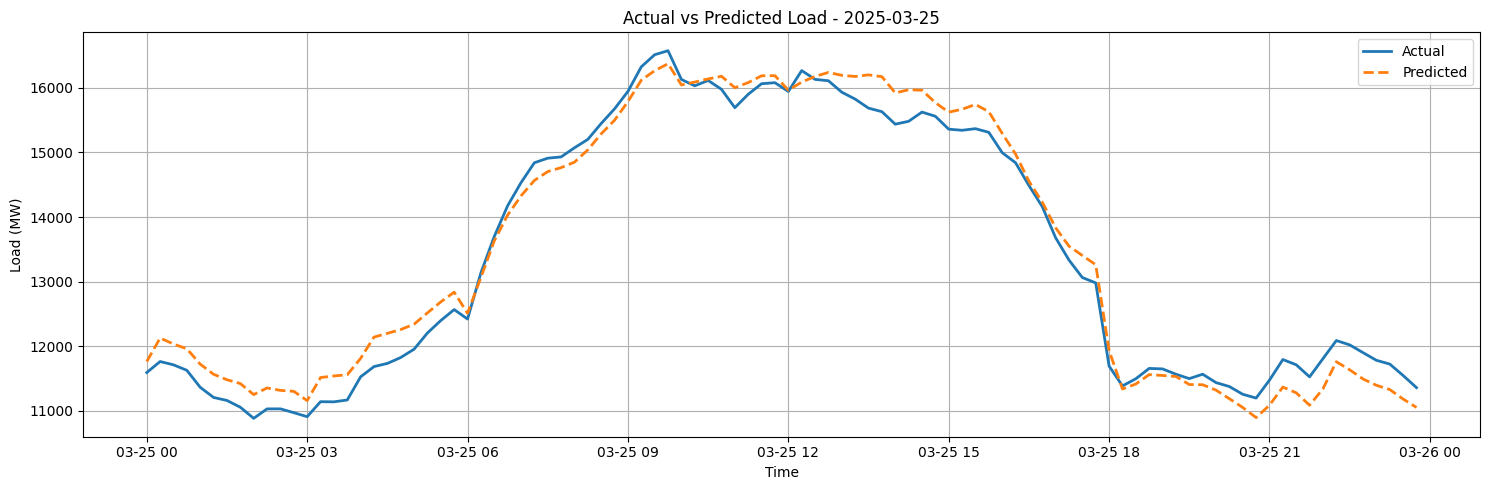

📊 Metrics ➤ MAE: 259.05, RMSE: 290.00, MAPE: 2.02%

📅 Predicting 2025-03-26 using training from: ['2025-03-21', '2025-03-22', '2025-03-23', '2025-03-24', '2025-03-25']
✅ Saved prediction to: /content/prediction/predicted2025-03-26.csv


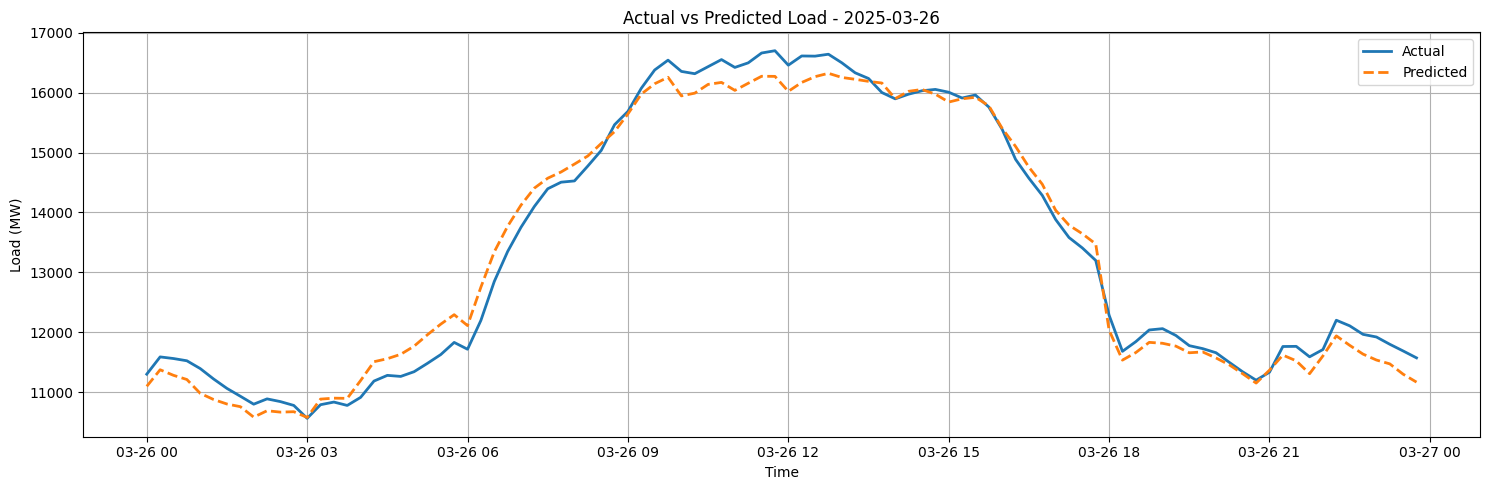

📊 Metrics ➤ MAE: 232.09, RMSE: 270.21, MAPE: 1.78%

📅 Predicting 2025-03-27 using training from: ['2025-03-22', '2025-03-23', '2025-03-24', '2025-03-25', '2025-03-26']
✅ Saved prediction to: /content/prediction/predicted2025-03-27.csv


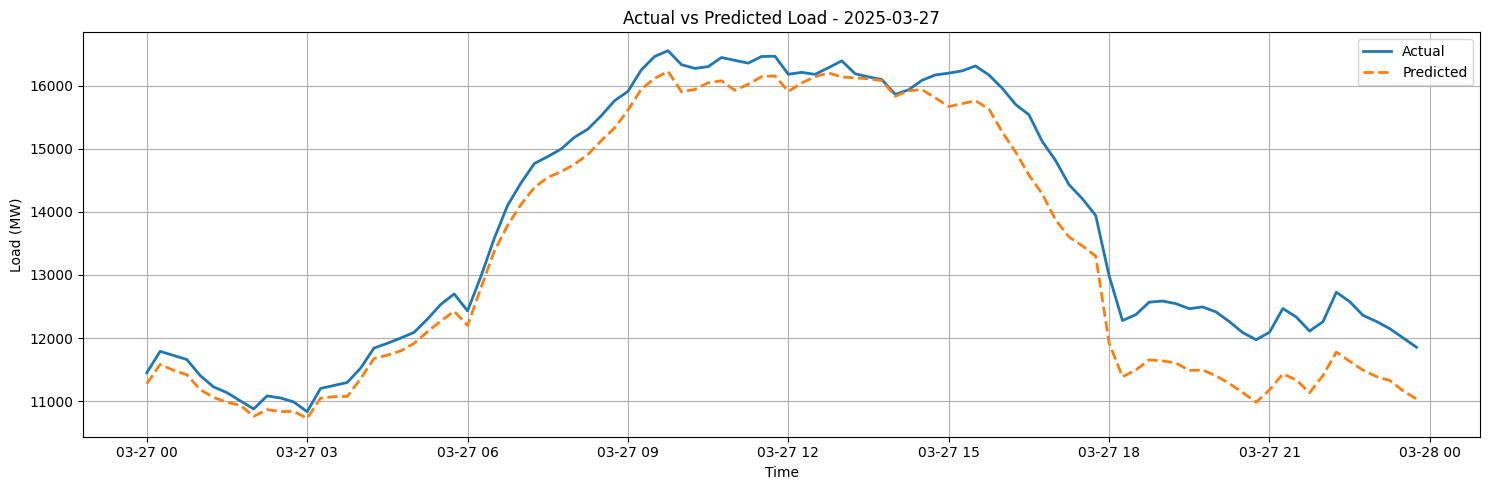

📊 Metrics ➤ MAE: 468.93, RMSE: 573.00, MAPE: 3.52%

📅 Predicting 2025-03-28 using training from: ['2025-03-23', '2025-03-24', '2025-03-25', '2025-03-26', '2025-03-27']
✅ Saved prediction to: /content/prediction/predicted2025-03-28.csv


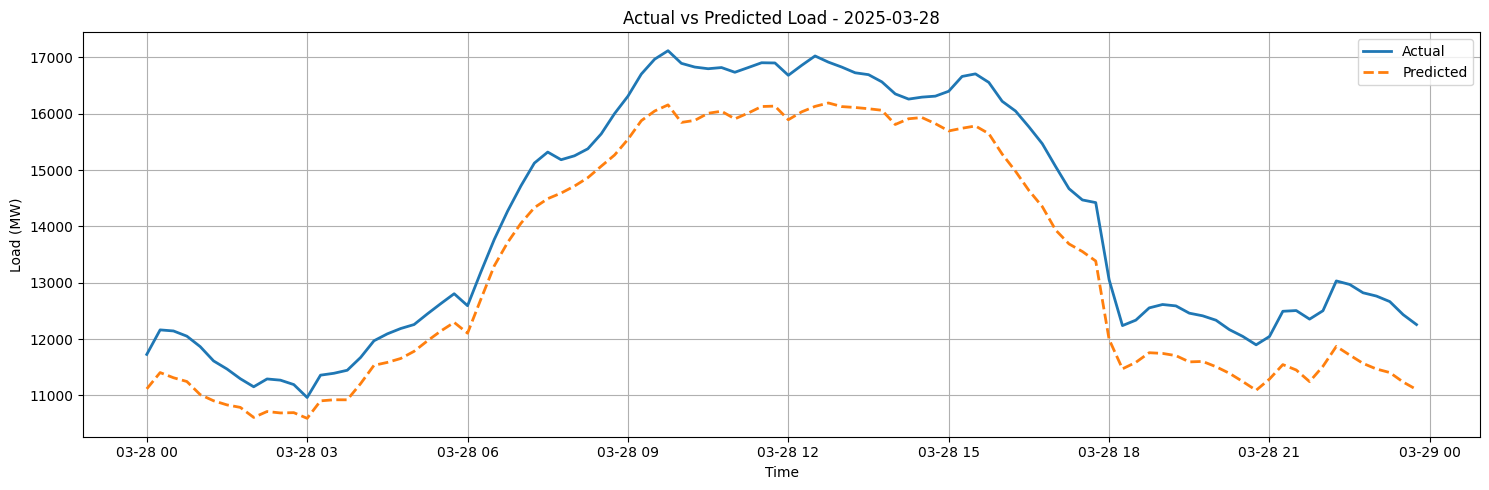

📊 Metrics ➤ MAE: 767.80, RMSE: 802.64, MAPE: 5.55%

📅 Predicting 2025-03-29 using training from: ['2025-03-24', '2025-03-25', '2025-03-26', '2025-03-27', '2025-03-28']
✅ Saved prediction to: /content/prediction/predicted2025-03-29.csv


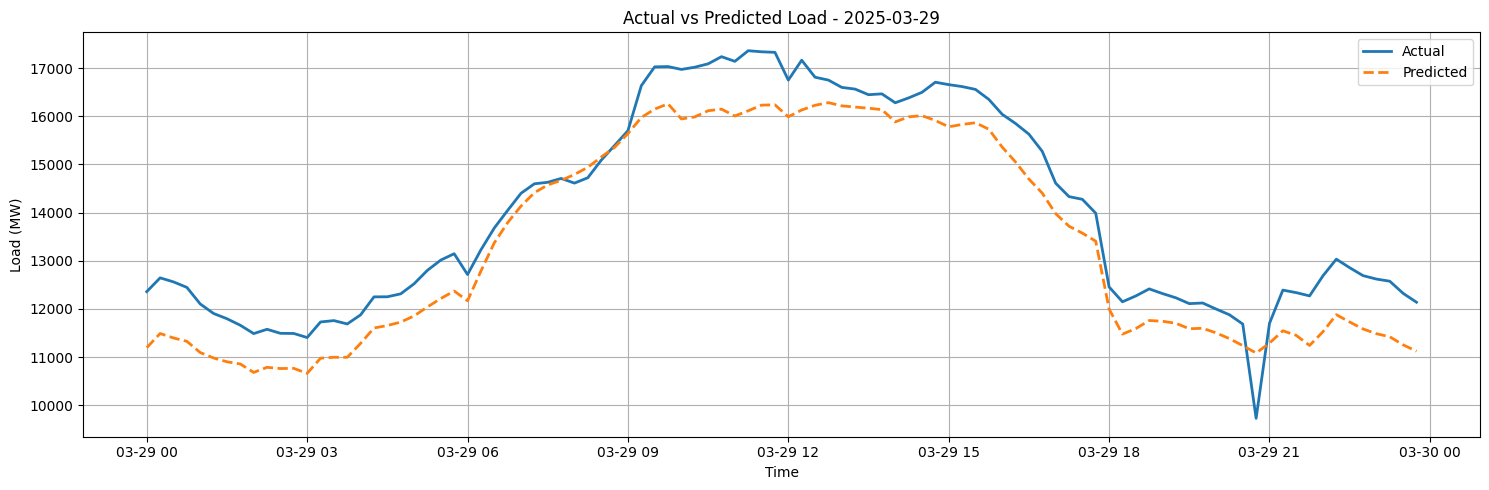

📊 Metrics ➤ MAE: 707.05, RMSE: 773.06, MAPE: 5.21%


In [ ]:
metrics_dict = {}
weights = initialize_weights(n_days=5)

for i, target_day in enumerate(['2025-03-25', '2025-03-26', '2025-03-27', '2025-03-28', '2025-03-29']):
    train_dates = [f"2025-03-{day:02d}" for day in range(20 + i, 25 + i)]
    print(f"\n📅 Predicting {target_day} using training from: {train_dates}")

    pred_df = predict_day(target_day, train_dates, weights)
    actual_file = os.path.join(data_dir, f"{target_day}.csv")
    metrics = evaluate_prediction(pred_df, actual_file, target_day)

    metrics_dict[target_day] = metrics
    print(f"📊 Metrics ➤ MAE: {metrics['MAE']:.2f}, RMSE: {metrics['RMSE']:.2f}, MAPE: {metrics['MAPE']:.2f}%")


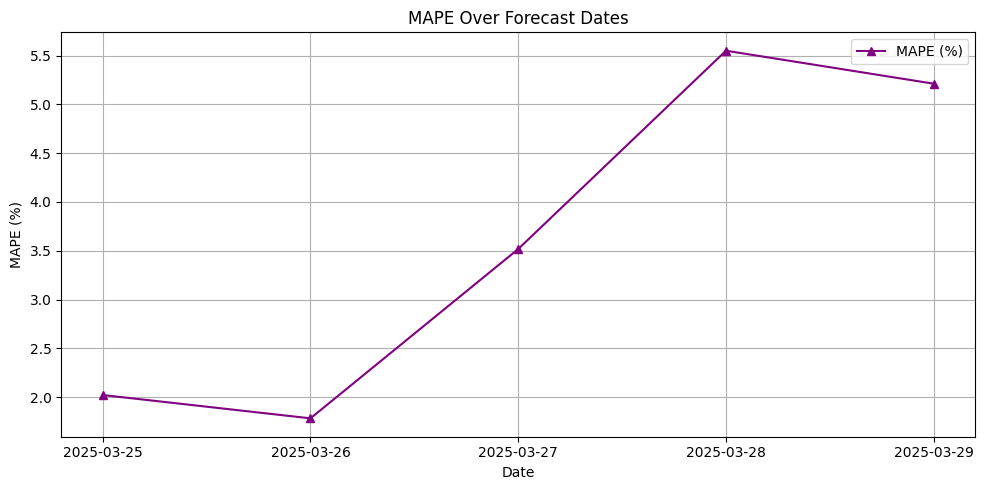

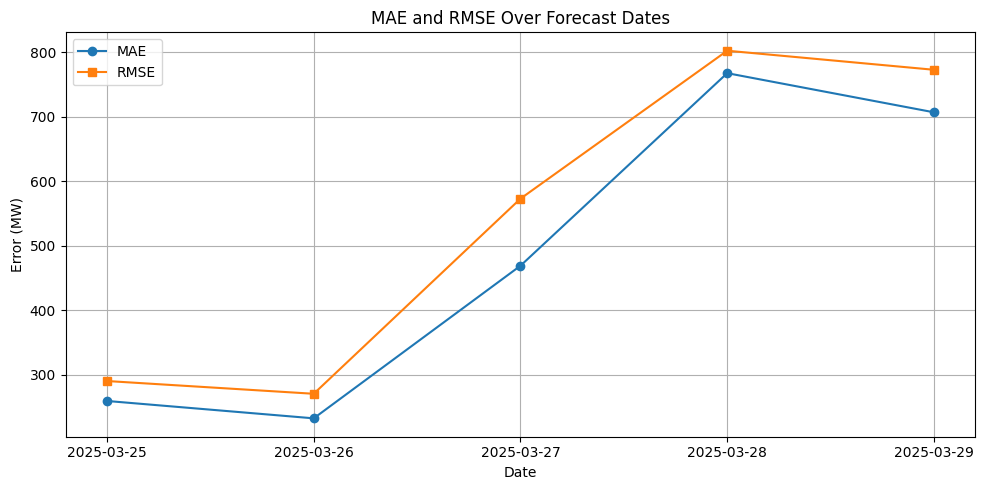

In [5]:
# Plot Date vs MAPE
dates = list(metrics_dict.keys())
mapes = [metrics_dict[d]['MAPE'] for d in dates]
maes = [metrics_dict[d]['MAE'] for d in dates]
rmses = [metrics_dict[d]['RMSE'] for d in dates]

plt.figure(figsize=(10, 5))
plt.plot(dates, mapes, marker='^', color='purple', label='MAPE (%)')
plt.title("MAPE Over Forecast Dates")
plt.xlabel("Date")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot MAE and RMSE together
plt.figure(figsize=(10, 5))
plt.plot(dates, maes, marker='o', label='MAE')
plt.plot(dates, rmses, marker='s', label='RMSE')
plt.title("MAE and RMSE Over Forecast Dates")
plt.xlabel("Date")
plt.ylabel("Error (MW)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
